In [402]:
import pandas as pd
from pandasql import sqldf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import random

In [403]:
VARIABLES = ['ActivityCounts', 'Barometer', 'BloodPerfusion',
             'BloodPulseWave', 'EnergyExpenditure', 'GalvanicSkinResponse', 'HR',
             'HRV', 'RESP', 'Steps', 'SkinTemperature', 'ActivityClass']

In [409]:
def plotter(day, dat):
    plt.figure()
    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=1.5,
                        wspace=0.4,
                        hspace=0.4)
    length = len(np.array([value if value != 'None' else None for value in dat['HR'][day].split(',')], dtype=float)) \
        if not isinstance(dat['HR'][day], np.ndarray) else len(dat['HR'][day]) # entry could be ndarray or string

    for i, variable in enumerate(VARIABLES):
        entry = dat[variable][day]
        time_series = np.array([value if value != 'None' else None for value in entry.split(',')], dtype=float) \
            if not isinstance(entry, np.ndarray) else entry # entry could be ndarray or string

        assert len(time_series) == length, 'time-series data lengths differ!'

        col = 'green' if dat['VAS'][day] == 0.0 else 'red'
        plt.subplot(3, 4, i+1)
        plt.title(variable)
        plt.plot(time_series, col)
        plt.xlim([0, length])

def na_visualizer(days, dat):
    for day in days:
        entry = np.array([value if value != 'None' else None for value in dat['ActivityCounts'][day].split(',')], dtype=float) \
            if not isinstance(dat['ActivityCounts'][day], np.ndarray) else dat['ActivityCounts'][day] # entry could be ndarray or string
        na_matrix = np.zeros((len(VARIABLES), entry.shape[0]))

        for i, variable in enumerate(VARIABLES):
            entry = dat[variable][day]
            time_series = np.array([value if value != 'None' else None for value in entry.split(',')], dtype=float) \
                if not isinstance(entry, np.ndarray) else entry # entry could be ndarray or string

            na_data = np.where(np.isnan(time_series), 0.0, 1.0)
            na_matrix[i, :] = na_data

        # hack: below makes sure colors in image are matched correctly (if all missing/no missing would break otherwise)
        na_matrix[1, 1] = 0.0
        na_matrix[2, 1] = 1.0

        # plot
        cmap = matplotlib.colors.ListedColormap(['red', 'green'])
        plt.figure()
        plt.imshow(na_matrix, cmap=cmap, aspect='20', interpolation='nearest')
        plt.title(f'day {day}')
        plt.xlabel('data length [min]')
        plt.ylabel('variable')

def na_sequence_lengths(dat):
    # check NA sequence lengths
    n_days, n_cols = dat.shape

    total_missing_values = 0
    na_sequences_data = []
    for day in range(n_days):
        for variable in VARIABLES:
            entry = dat[variable][day]
            time_series = np.array([value if value != 'None' else None for value in entry.split(',')], dtype=float) \
                if not isinstance(entry, np.ndarray) else entry # entry could be ndarray or string

            na_sequences = []
            na_seq = 0
            for datapoint in time_series:
                if not np.isnan(datapoint):
                    if na_seq > 0:
                        na_sequences.append(na_seq)
                        total_missing_values += na_seq
                        na_seq = 0
                else:
                    # datapoint is NA
                    na_seq += 1
            na_sequences_data += na_sequences

    # show numerical distribution of NA sequence lengths
    temp = pd.DataFrame(np.array(na_sequences_data), columns=['n'])
    query = '''
    SELECT n AS sequence_length, COUNT(*) AS occurrences
    FROM temp
    GROUP BY n;'''
    temp = sqldf(query)

    # plot distribution of NA sequence lengths
    temp.plot.bar(x='sequence_length', y='occurrences', width=2, title=f'Missing data (total: {total_missing_values})')
    plt.xticks([])
    plt.xlim([-10, temp.shape[0]])

    return temp

def imputer(dat, max_fill=300):
    dat2 = dat.copy()

    for variable in VARIABLES:
        time_series_all_days = []
        for day in range(dat2.shape[0]):
            entry = dat2[variable][day]
            time_series = np.array([value if value != 'None' else None for value in entry.split(',')], dtype=float) \
                if not isinstance(entry, np.ndarray) else entry # entry could be ndarray or string
            time_series_all_days.append(time_series)

        pre_imputation = pd.DataFrame(time_series_all_days)
        post_imputation = pre_imputation.interpolate(method='linear', axis=1, limit=max_fill)

        # update dataframe with imputation data
        for day in range(dat2.shape[0]):
            dat2[variable].iloc[day] = np.array(post_imputation.iloc[day])

    return dat2

# Import data

In [405]:
# file path to data folder
path = './Output'

In [406]:
file = path + f'/combined_data.csv'
data = pd.read_csv(file, index_col=0).fillna(pd.NA)

Visualization: plot random day of dataset (<span style="color:red">fatigued</span>, <span style="color:green">vigilant</span>)

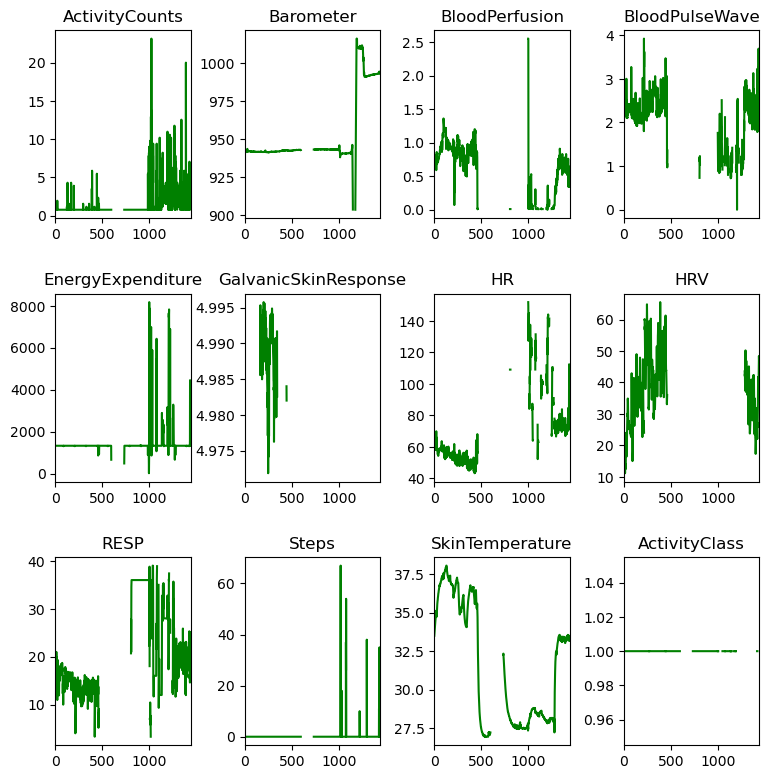

In [407]:
day = random.sample(range(data.shape[0]), 1)[0]
plotter(day, data)

# Imputation

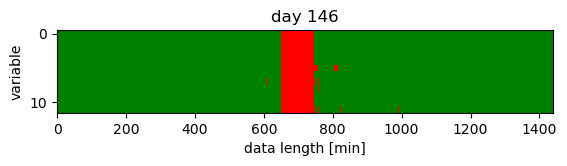

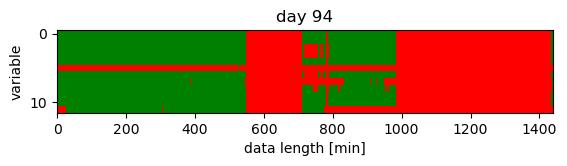

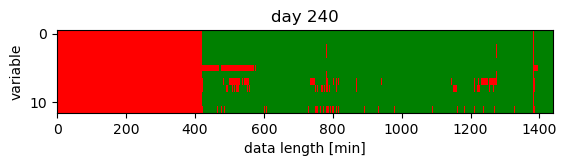

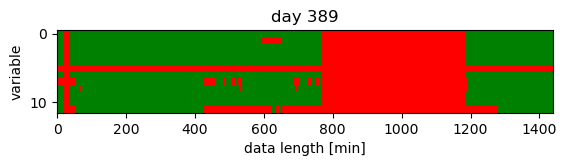

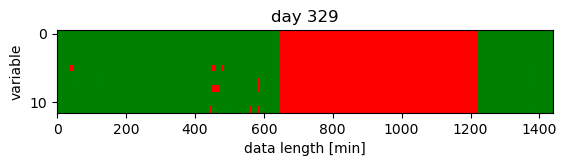

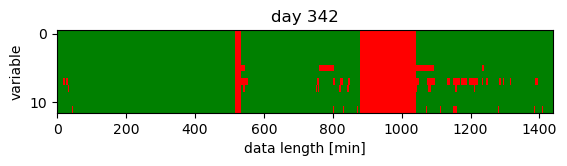

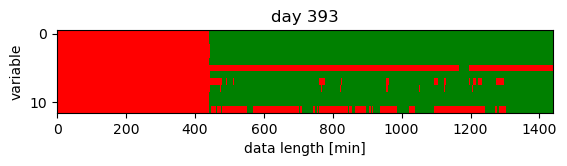

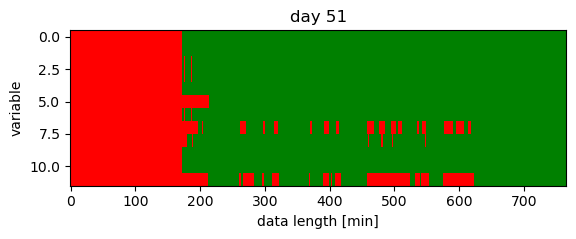

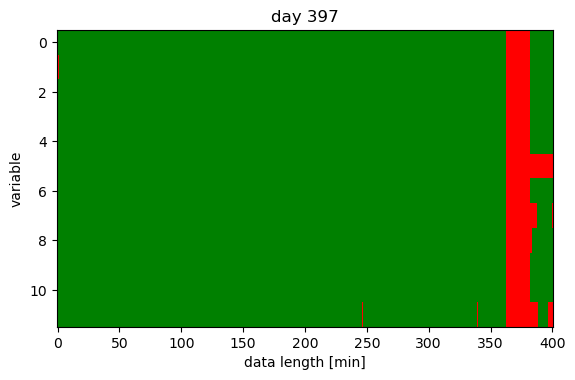

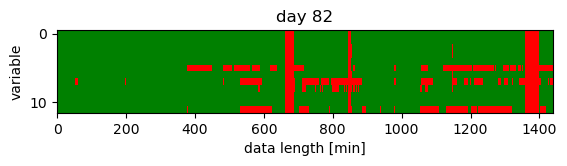

In [410]:
# visualize missing data
N = 10
days = np.random.choice(data.shape[0], N, replace=False)
na_visualizer(days, data)

,sequence_length,occurrences
0,1,10442
1,2,4282
2,3,1974
3,4,1273
4,5,891
...,...,...
559,1165,1
560,1175,1
561,1270,11
562,1354,12


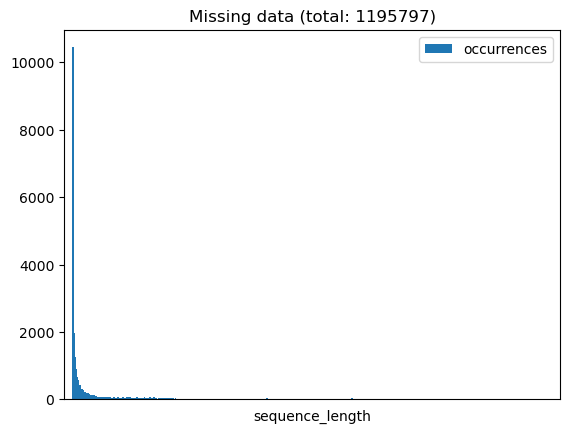

In [411]:
# before imputation
na_sequence_lengths(data)

In [412]:
# imputation
MAX_FILL = 100
data_imputed = imputer(data, max_fill=MAX_FILL)

C:\Users\jjung\AppData\Local\Temp\ipykernel_4104\2250644295.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat2[variable].iloc[day] = np.array(post_imputation.iloc[day])


,sequence_length,occurrences
0,1,65
1,2,55
2,3,45
3,4,31
4,5,40
...,...,...
482,1165,1
483,1170,11
484,1175,1
485,1354,12


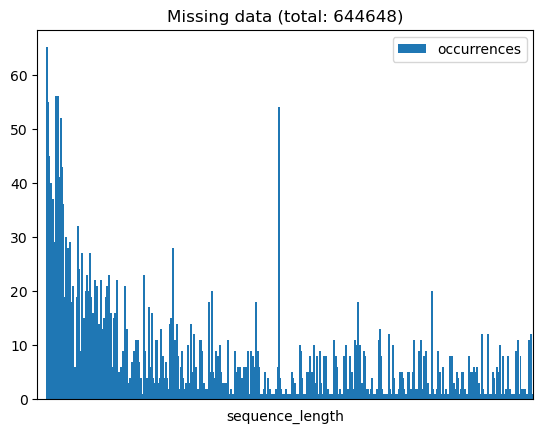

In [413]:
# after imputation
na_sequence_lengths(data_imputed)

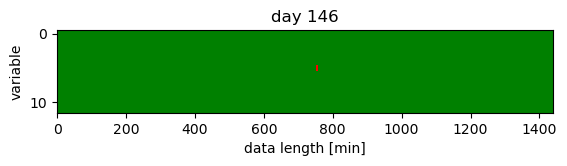

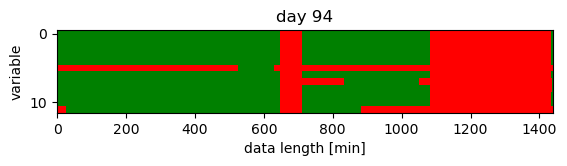

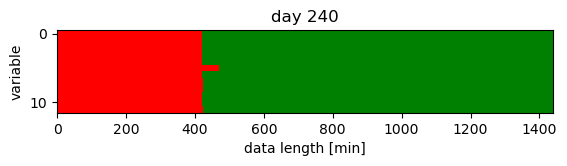

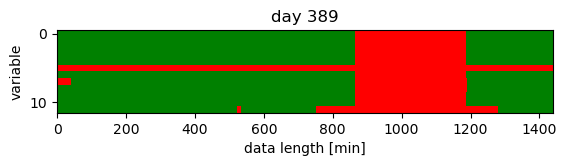

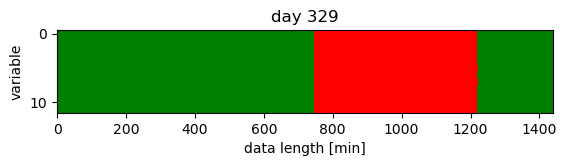

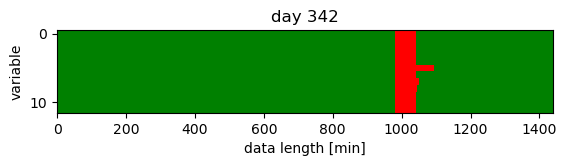

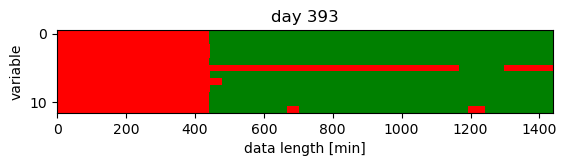

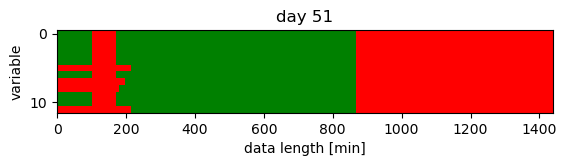

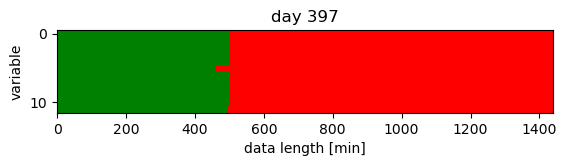

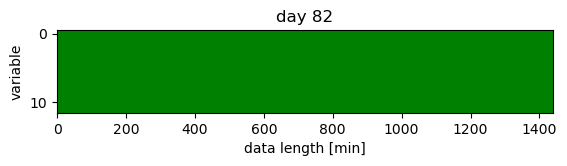

In [414]:
na_visualizer(days, data_imputed)

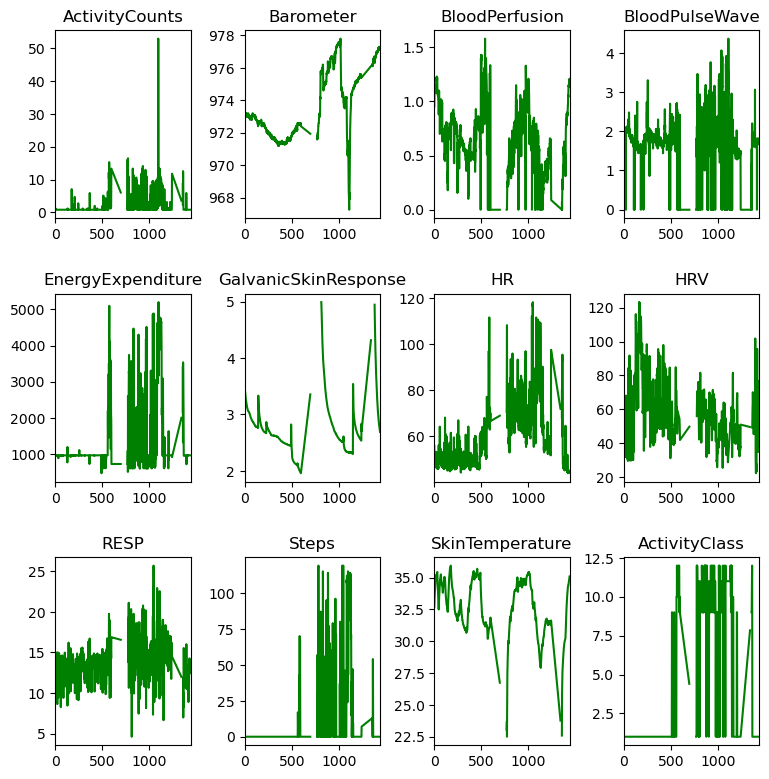

In [422]:
day = 237 # day 237 is good for visualization
#day = np.random.choice(days, 1)[0] # otherwise random day
plotter(day, data_imputed)

# Segmentation

segment into dataframes with no missing data

In [423]:
# count total time [min] (incl. missing data)
total_time = 0
for day in range(data.shape[0]):
    entry = data[VARIABLES[0]][day]
    time_series = np.array([value if value != 'None' else None for value in entry.split(',')], dtype=float) \
        if not isinstance(entry, np.ndarray) else entry # entry could be ndarray or string

    total_time += len(time_series)

print(f'Total time (incl.missing data) before segmentation: {total_time} min')

Total time (incl.missing data) before segmentation: 568317 min


In [424]:
# segment into dataframes with no missing data
segments = {} # time indices of days (in min)

for day in range(data_imputed.shape[0]):
    entry = np.array([value if value != 'None' else None for value in data_imputed['ActivityCounts'][day].split(',')], dtype=float) \
        if not isinstance(data_imputed['ActivityCounts'][day], np.ndarray) else data_imputed['ActivityCounts'][day] # entry could be ndarray or string

    # check where is missing data
    na_matrix = np.zeros((len(VARIABLES), entry.shape[0]))
    for i, variable in enumerate(VARIABLES):
        entry = data_imputed[variable][day]
        time_series = np.array([value if value != 'None' else None for value in entry.split(',')], dtype=float) \
            if not isinstance(entry, np.ndarray) else entry # entry could be ndarray or string

        na_data = np.where(np.isnan(time_series), 0.0, 1.0) # 0.0: NA, 1.0: data
        na_matrix[i, :] = na_data

    # segment
    segments_indices = []
    segment_start_col = 0
    segment_end_col = 0

    rows, cols = na_matrix.shape
    for col in range(cols):
        # check if NA in column
        if 0.0 in na_matrix[:, col]:
            # check if data before
            if segment_start_col != segment_end_col:
                segments_indices.append((segment_start_col, segment_end_col))

            segment_end_col = segment_start_col = col

        # accept column into segment sequence
        segment_end_col = col

    # check if final sequence contains data
    if segment_start_col != segment_end_col:
        segments_indices.append((segment_start_col, segment_end_col))

    segments[day] = segments_indices

In [425]:
segments

{0: [],
 1: [],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [],
 7: [],
 8: [(94, 654)],
 9: [(0, 544), (646, 1227), (1338, 1439)],
 10: [(0, 1180)],
 11: [(34, 522), (523, 557), (571, 676), (826, 1048), (1102, 1439)],
 12: [(0, 562), (700, 1439)],
 13: [(0, 488), (692, 814), (882, 1055), (1068, 1203), (1236, 1439)],
 14: [(0, 469), (556, 605), (607, 809), (823, 1202), (1224, 1439)],
 15: [(0, 538), (632, 806), (914, 1439)],
 16: [(460, 569), (588, 770), (778, 1439)],
 17: [(114, 265), (291, 728)],
 18: [(396, 528), (562, 653), (680, 792), (878, 1299)],
 19: [(507, 526), (531, 623), (1005, 1222)],
 20: [(238, 529), (550, 633), (960, 1249)],
 21: [(64, 600), (605, 692), (1130, 1179), (1252, 1439)],
 22: [(0, 738)],
 23: [(0, 402), (403, 854), (872, 1170), (1308, 1439)],
 24: [(0, 450), (619, 991), (1042, 1256), (1273, 1439)],
 25: [(580, 605), (776, 902), (959, 1191), (1214, 1439)],
 26: [(506, 871), (1043, 1301)],
 27: [(471, 1439)],
 28: [(544, 650)],
 29: [(0, 104)],
 30: [],
 31: [],
 32: [

In [431]:
discarded_days = sum([1 if len(sequence) == 0 else 0 for sequence in segments.values()])
print(f'Discarded days because of missing data in at least one variable: {discarded_days}')
print(f'Days left: {data.shape[0] - discarded_days}')

Discarded days because of missing data in at least one variable: 45
Days left: 365


In [432]:
# count total time [min] (after segmentation)
total_time2 = sum([sum([tupl[1] - tupl[0] + 1 for tupl in sequence]) if len(sequence) != 0 else 0 for sequence in segments.values()])

print(f'Total time after segmentation: {total_time2} min ({round(100 * total_time2 / total_time, 2)}% compared to before)')

Total time after segmentation: 376692 min (66.28% compared to before)


# Filter sequences

# Spectrogram conversion

In [433]:
SAMPLING_RATE = 1/60

C:\Users\jjung\anaconda3\envs\ai\lib\site-packages\matplotlib\axes\_axes.py:7622: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


<Figure size 640x480 with 0 Axes>

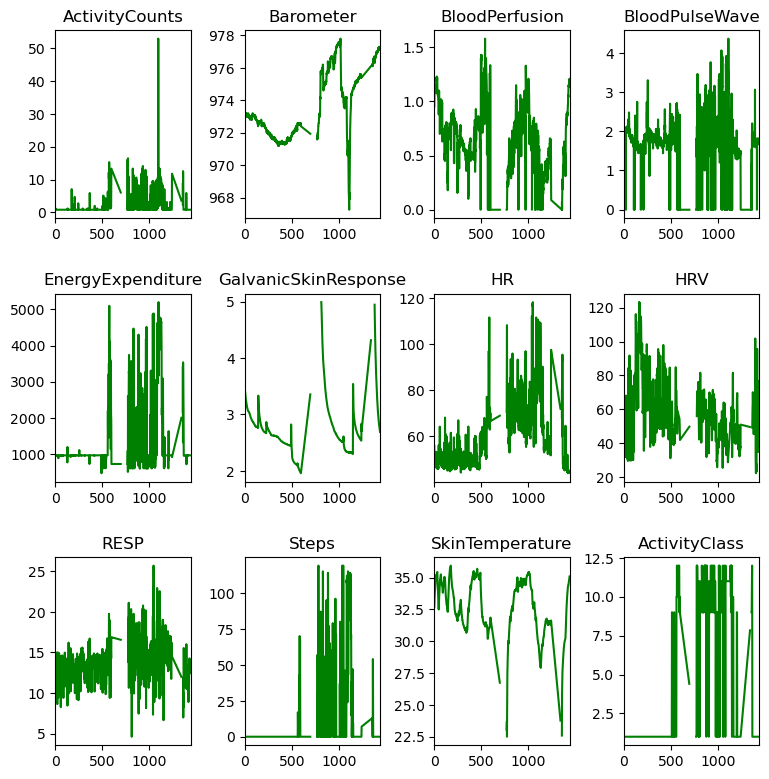

<Figure size 640x480 with 0 Axes>

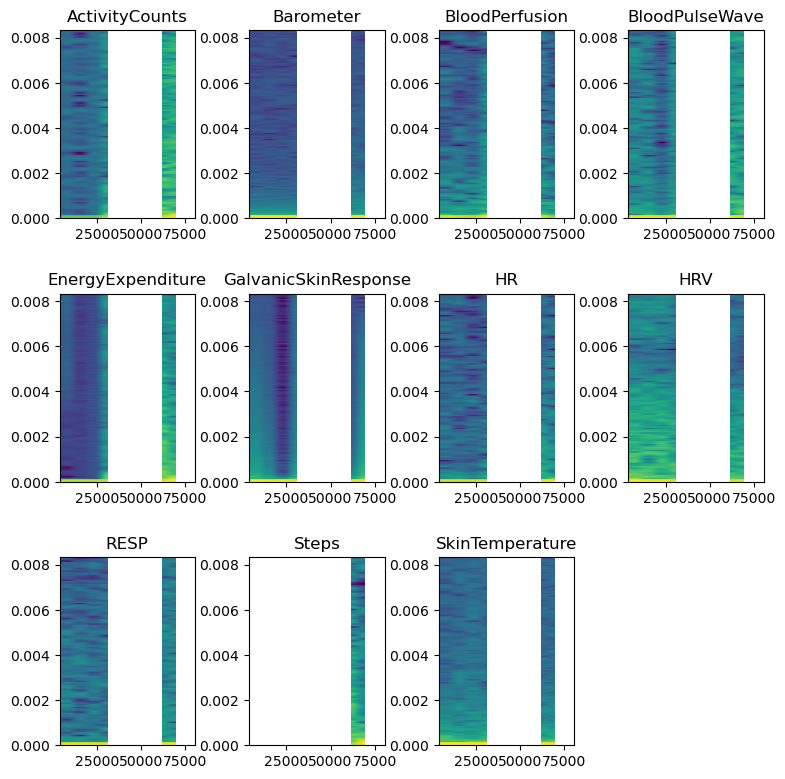

In [434]:
#from scipy import signal
def plotter_spec(day, dat):
    plt.figure()
    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=1.5,
                        wspace=0.4,
                        hspace=0.4)
    length = len(np.array([value if value != 'None' else None for value in dat['HR'][day].split(',')], dtype=float)) \
        if not isinstance(dat['HR'][day], np.ndarray) else len(dat['HR'][day]) # entry could be ndarray or string

    for i, variable in enumerate(VARIABLES):
        entry = dat[variable][day]
        time_series = np.array([value if value != 'None' else None for value in entry.split(',')], dtype=float) \
            if not isinstance(entry, np.ndarray) else entry # entry could be ndarray or string

        assert len(time_series) == length, 'time-series data lengths differ!'

        col = 'green' if dat['VAS'][day] == 0.0 else 'red'
        if variable != 'ActivityClass': # TODO: ActivityClass is categorical variable
            plt.subplot(3, 4, i+1)
            plt.title(variable)
            #plt.specgram(time_series, NFFT=128, Fs=10e7, noverlap=120, cmap='jet_r')
            plt.specgram(time_series, Fs=SAMPLING_RATE)
            #f, t, Sxx = signal.spectrogram(time_series, 10e3)
            #plt.pcolormesh(t, f, Sxx, shading='gouraud')

            #plt.xlim([0, length])

day = 237

fig = plt.figure()
plotter(day, data_imputed)

fig = plt.figure()
plotter_spec(day, data_imputed)

(1200,)


(array([[2.45156859e+07, 2.43866429e+07, 2.45341726e+07, ...,
                    nan,            nan,            nan],
        [1.27608040e+07, 1.28202667e+07, 1.24776708e+07, ...,
                    nan,            nan,            nan],
        [1.26649247e+04, 3.81217363e+04, 2.94493349e+03, ...,
                    nan,            nan,            nan],
        ...,
        [7.57851448e+02, 1.51804534e+03, 1.12134092e+01, ...,
                    nan,            nan,            nan],
        [7.60413387e+02, 8.91559680e+02, 3.79260889e+01, ...,
                    nan,            nan,            nan],
        [5.84577623e+02, 5.30209845e+01, 6.23267982e+01, ...,
                    nan,            nan,            nan]]),
 array([0.00000000e+00, 6.51041667e-05, 1.30208333e-04, 1.95312500e-04,
        2.60416667e-04, 3.25520833e-04, 3.90625000e-04, 4.55729167e-04,
        5.20833333e-04, 5.85937500e-04, 6.51041667e-04, 7.16145833e-04,
        7.81250000e-04, 8.46354167e-04, 9.1145833

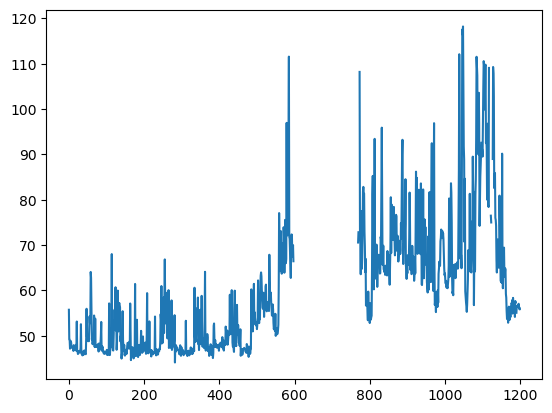

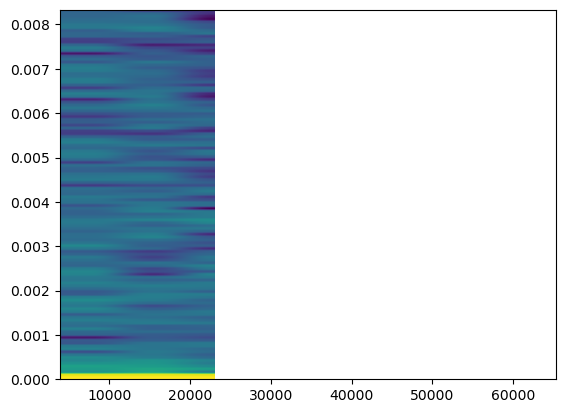

In [435]:
entry = data['HR'][237]
time_series = np.array([value if value != 'None' else None for value in entry.split(',')], dtype=float) \
    if not isinstance(entry, np.ndarray) else entry # entry could be ndarray or string
time_series = time_series.copy()[:1200]
print(time_series.shape)
plt.plot(time_series)
plt.figure()
plt.specgram(time_series, Fs=SAMPLING_RATE)

(array([[2.45156859e+07, 2.43866429e+07, 2.45341726e+07, ...,
                    nan,            nan, 5.37267336e+07],
        [1.27608040e+07, 1.28202667e+07, 1.24776708e+07, ...,
                    nan,            nan, 2.47922413e+07],
        [1.26649247e+04, 3.81217363e+04, 2.94493349e+03, ...,
                    nan,            nan, 7.33834130e+04],
        ...,
        [7.57851448e+02, 1.51804534e+03, 1.12134092e+01, ...,
                    nan,            nan, 1.64398627e+03],
        [7.60413387e+02, 8.91559680e+02, 3.79260889e+01, ...,
                    nan,            nan, 4.33424483e+03],
        [5.84577623e+02, 5.30209845e+01, 6.23267982e+01, ...,
                    nan,            nan, 3.60101498e+02]]),
 array([0.00000000e+00, 6.51041667e-05, 1.30208333e-04, 1.95312500e-04,
        2.60416667e-04, 3.25520833e-04, 3.90625000e-04, 4.55729167e-04,
        5.20833333e-04, 5.85937500e-04, 6.51041667e-04, 7.16145833e-04,
        7.81250000e-04, 8.46354167e-04, 9.1145833

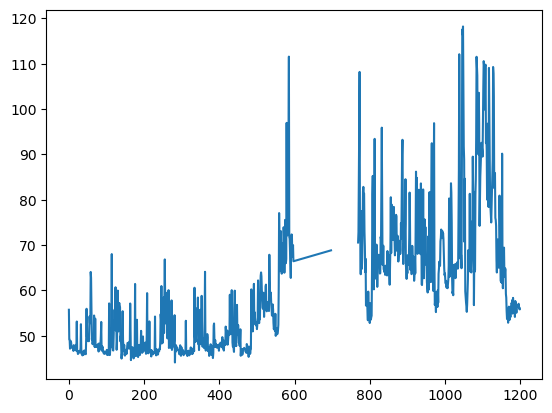

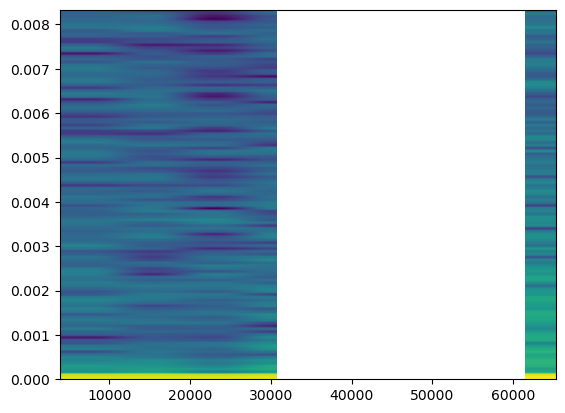

In [436]:
entry = data['HR'][237]
time_series = np.array([value if value != 'None' else None for value in entry.split(',')], dtype=float) \
    if not isinstance(entry, np.ndarray) else entry # entry could be ndarray or string
time_series = time_series.copy()[:1200]
time_series = pd.DataFrame(time_series)
time_series = time_series.interpolate(method='linear', axis=0, limit=100)
temp = time_series.to_numpy().reshape((1200, ))
plt.plot(time_series)
plt.figure()
plt.specgram(temp, Fs=SAMPLING_RATE)

(array([[2.45156859e+07, 2.43866429e+07, 2.45341726e+07, ...,
         4.86938458e+07, 4.98458854e+07, 5.37267336e+07],
        [1.27608040e+07, 1.28202667e+07, 1.24776708e+07, ...,
         2.51680198e+07, 2.65705941e+07, 2.47922413e+07],
        [1.26649247e+04, 3.81217363e+04, 2.94493349e+03, ...,
         5.73182140e+04, 1.38916587e+04, 7.33834130e+04],
        ...,
        [7.57851448e+02, 1.51804534e+03, 1.12134092e+01, ...,
         1.39321453e+03, 2.93563718e+02, 1.64398627e+03],
        [7.60413387e+02, 8.91559680e+02, 3.79260889e+01, ...,
         1.92764112e+03, 7.64139304e+02, 4.33424483e+03],
        [5.84577623e+02, 5.30209845e+01, 6.23267982e+01, ...,
         9.01977132e+02, 5.12711536e+02, 3.60101498e+02]]),
 array([0.00000000e+00, 6.51041667e-05, 1.30208333e-04, 1.95312500e-04,
        2.60416667e-04, 3.25520833e-04, 3.90625000e-04, 4.55729167e-04,
        5.20833333e-04, 5.85937500e-04, 6.51041667e-04, 7.16145833e-04,
        7.81250000e-04, 8.46354167e-04, 9.1145833

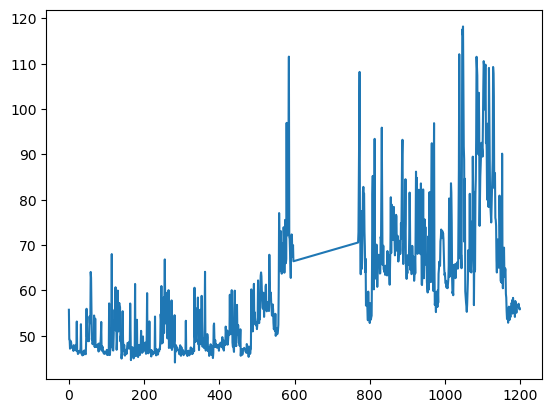

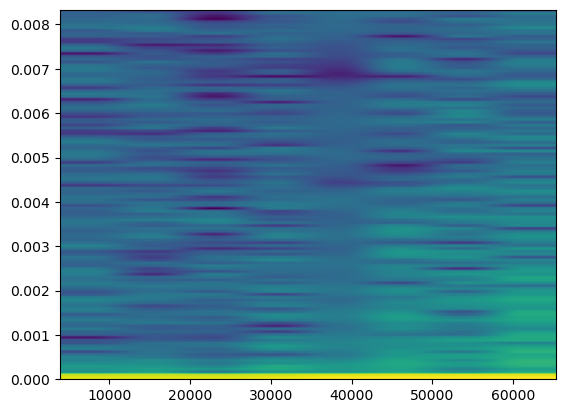

In [437]:
entry = data['HR'][237]
time_series = np.array([value if value != 'None' else None for value in entry.split(',')], dtype=float) \
    if not isinstance(entry, np.ndarray) else entry # entry could be ndarray or string
time_series = time_series.copy()[:1200]
time_series = pd.DataFrame(time_series)
time_series = time_series.interpolate(method='linear', axis=0)
temp = time_series.to_numpy().reshape((1200, ))
plt.plot(time_series)
plt.figure()
plt.specgram(temp, Fs=SAMPLING_RATE)

# Feature vector

ReIP and timezone into feature vector